ERROR 1: PROJ: proj_create_from_database: Open of /lfs/opt/anaconda3/share/proj failed


pH data successfully extracted.
dthr (Range: max - min of hist pH): 0.1735
pH Threshold (10th percentile, from hist): 8.1491
pH Threshold (5th percentile, from hist): 8.1407

--- pH Risk Metrics ---

pH Threshold: 10th percentile (Value = 8.1491)
Historical pH:
  Normalized Intensity: 0.0536 ± 0.0003
  Exceedance Probability: 0.1000 ± 0.0008
  Hazard: 0.0054 ± 0.0001
Future SSP pH:
  Normalized Intensity: 0.1067 ± 0.0004
  Exceedance Probability: 0.2367 ± 0.0011
  Hazard: 0.0253 ± 0.0002

pH Threshold: 5th percentile (Value = 8.1407)
Historical pH:
  Normalized Intensity: 0.0352 ± 0.0003
  Exceedance Probability: 0.0500 ± 0.0006
  Hazard: 0.0018 ± 0.0000
Future SSP pH:
  Normalized Intensity: 0.0856 ± 0.0005
  Exceedance Probability: 0.1766 ± 0.0010
  Hazard: 0.0151 ± 0.0001

Return Level for T = 30 years (pH):
  Historical: 8.1368 ± 0.0001
  Future SSP: 8.1146 ± 0.0001


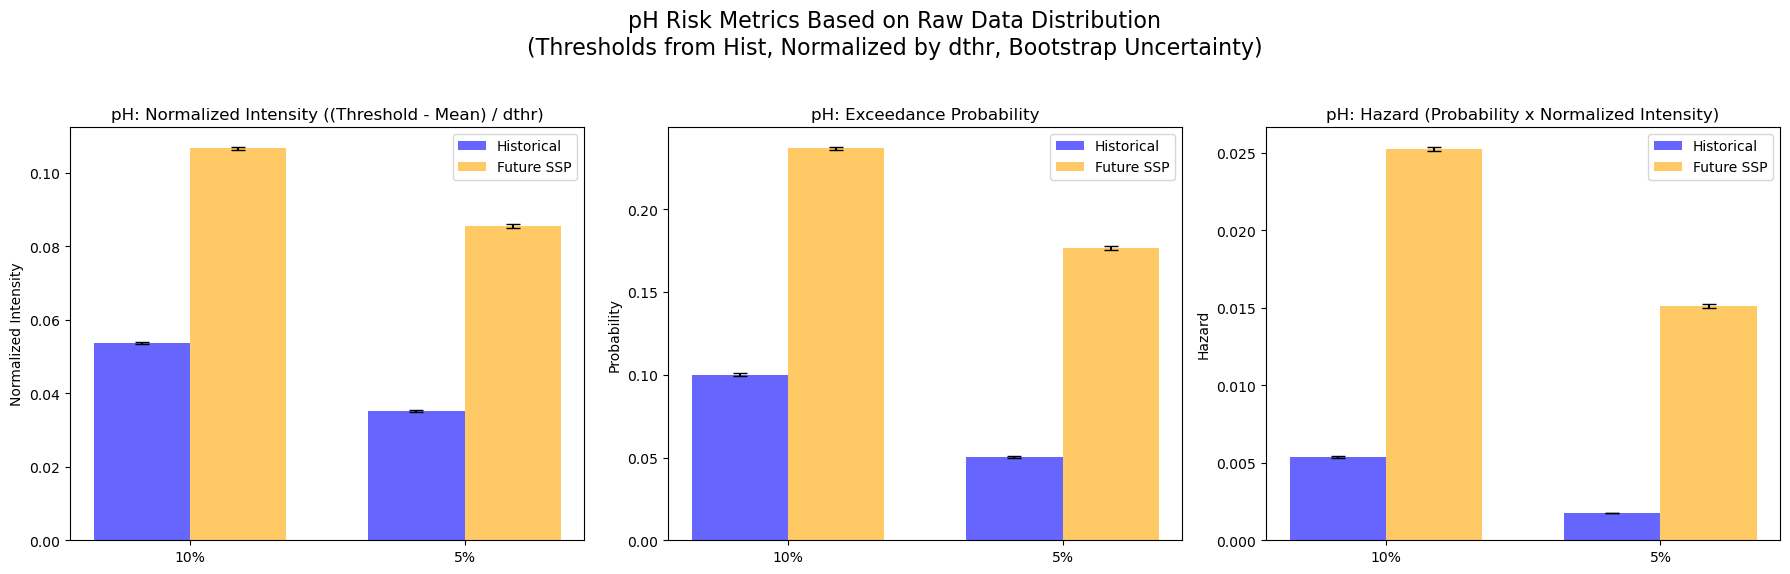

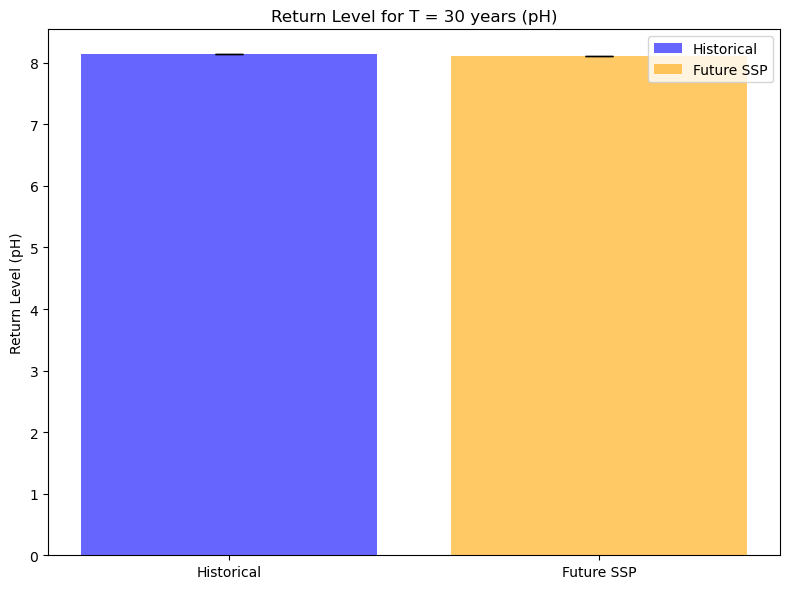

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Parameter Settings and Data Reading
# ------------------------------
outdir = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/"
ship = "gb"

# File paths for historical and Future SSP pH data
file_hist = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/predicted_pH_hist_{ship}.nc"
file_ssp  = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/predicted_pH_ssp_{ship}.nc"

n_bootstrap = 1000

try:
    data_hist = xr.open_dataset(file_hist)
    data_ssp  = xr.open_dataset(file_ssp)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

try:
    pH_hist = data_hist['predicted_pH'].values.flatten()
    pH_ssp  = data_ssp['predicted_pH'].values.flatten()
    print("pH data successfully extracted.")
except KeyError as e:
    print(f"Error: Variable 'predicted_pH_corrected' not found in one of the datasets. {e}")
    exit()

# ------------------------------
# Define dthr from Historical pH Data as Range (100%-0%)
# ------------------------------
dthr = np.max(pH_hist) - np.min(pH_hist)
print(f"dthr (Range: max - min of hist pH): {dthr:.4f}")

# ------------------------------
# Define Left-Tail Metric Calculation Functions
# ------------------------------
def calc_metrics_left(data, threshold, dthr):
    """
    Calculate left-tail risk metrics for pH.
    
    For left-tail analysis (i.e. low pH is extreme):
      - Exceedance probability: fraction of data with pH < threshold.
      - Normalized intensity: (threshold - mean(pH below threshold)) / dthr.
      - Hazard: product of exceedance probability and normalized intensity.
    
    :param data: 1D numpy array.
    :param threshold: Left-tail threshold (e.g., 10th or 5th percentile).
    :param dthr: Range of historical pH.
    :return: (exceedance_prob, intensity, hazard)
    """
    mask = data < threshold
    n_total = len(data)
    n_exceed = np.sum(mask)
    if n_exceed == 0:
        return 0, np.nan, 0
    prob = n_exceed / n_total
    intensity = (threshold - np.mean(data[mask])) / dthr
    hazard = prob * intensity
    return prob, intensity, hazard

def bootstrap_metrics_left(data, threshold, dthr, n_bootstrap=1000):
    """
    Bootstrap resampling for left-tail risk metrics.
    Returns mean and half the 95% CI width (symmetric error) for each metric.
    """
    boot_probs = []
    boot_intensities = []
    boot_hazards = []
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        prob, inten, haz = calc_metrics_left(sample, threshold, dthr)
        if np.isnan(inten):
            continue
        boot_probs.append(prob)
        boot_intensities.append(inten)
        boot_hazards.append(haz)
    if len(boot_probs)==0:
        return (0,0), (np.nan,0), (0,0)
    boot_probs = np.array(boot_probs)
    boot_intensities = np.array(boot_intensities)
    boot_hazards = np.array(boot_hazards)
    
    def summary(arr):
        m = np.mean(arr)
        ci_lower = np.percentile(arr, 2.5)
        ci_upper = np.percentile(arr, 97.5)
        err = (ci_upper - ci_lower) / 2
        return m, err
    
    return summary(boot_probs), summary(boot_intensities), summary(boot_hazards)

# ------------------------------
# Define Left-Tail Return Level Calculation Functions for T = 30 years
# ------------------------------
def calc_return_level_left(data, T):
    """
    For left-tail extremes, calculate the return level for T years as the (100/T)th percentile.
    
    :param data: 1D numpy array.
    :param T: Return period (years).
    :return: return level (in pH)
    """
    quantile_level = 100 / T
    return np.percentile(data, quantile_level)

def bootstrap_return_level_left(data, T, n_bootstrap=1000):
    boot_levels = []
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        level = calc_return_level_left(sample, T)
        boot_levels.append(level)
    boot_levels = np.array(boot_levels)
    mean_level = np.mean(boot_levels)
    ci_lower = np.percentile(boot_levels, 2.5)
    ci_upper = np.percentile(boot_levels, 97.5)
    err = (ci_upper - ci_lower) / 2
    return mean_level, err

# ------------------------------
# Settings for Analysis (Thresholds)
# ------------------------------
# For left-tail pH analysis, use 10th and 5th percentiles of historical pH.
threshold_percents = [10, 5]

results_pH = {
    'probability': {'hist': [], 'ssp': []},
    'intensity': {'hist': [], 'ssp': []},
    'hazard': {'hist': [], 'ssp': []},
    'thresholds': []  # actual threshold values from historical pH
}

# ------------------------------
# Analysis for pH Risk Metrics (Left-tail)
# ------------------------------
for perc in threshold_percents:
    thresh_value = np.percentile(pH_hist, perc)
    results_pH['thresholds'].append(thresh_value)
    print(f"pH Threshold ({perc}th percentile, from hist): {thresh_value:.4f}")
    
    # Historical pH metrics
    prob_h, inten_h, haz_h = calc_metrics_left(pH_hist, thresh_value, dthr)
    (mean_prob_h, err_prob_h), (mean_inten_h, err_inten_h), (mean_haz_h, err_haz_h) = bootstrap_metrics_left(pH_hist, thresh_value, dthr, n_bootstrap)
    results_pH['probability']['hist'].append((mean_prob_h, err_prob_h))
    results_pH['intensity']['hist'].append((mean_inten_h, err_inten_h))
    results_pH['hazard']['hist'].append((mean_haz_h, err_haz_h))
    
    # Future SSP pH metrics (using same threshold)
    prob_s, inten_s, haz_s = calc_metrics_left(pH_ssp, thresh_value, dthr)
    (mean_prob_s, err_prob_s), (mean_inten_s, err_inten_s), (mean_haz_s, err_haz_s) = bootstrap_metrics_left(pH_ssp, thresh_value, dthr, n_bootstrap)
    results_pH['probability']['ssp'].append((mean_prob_s, err_prob_s))
    results_pH['intensity']['ssp'].append((mean_inten_s, err_inten_s))
    results_pH['hazard']['ssp'].append((mean_haz_s, err_haz_s))

print("\n--- pH Risk Metrics ---")
for i, perc in enumerate(threshold_percents):
    thresh_value = results_pH['thresholds'][i]
    print(f"\npH Threshold: {perc}th percentile (Value = {thresh_value:.4f})")
    
    intensity_hist, intensity_hist_err = results_pH['intensity']['hist'][i]
    prob_hist, prob_hist_err = results_pH['probability']['hist'][i]
    hazard_hist, hazard_hist_err = results_pH['hazard']['hist'][i]
    print("Historical pH:")
    print(f"  Normalized Intensity: {intensity_hist:.4f} ± {intensity_hist_err:.4f}")
    print(f"  Exceedance Probability: {prob_hist:.4f} ± {prob_hist_err:.4f}")
    print(f"  Hazard: {hazard_hist:.4f} ± {hazard_hist_err:.4f}")
    
    intensity_ssp, intensity_ssp_err = results_pH['intensity']['ssp'][i]
    prob_ssp, prob_ssp_err = results_pH['probability']['ssp'][i]
    hazard_ssp, hazard_ssp_err = results_pH['hazard']['ssp'][i]
    print("Future SSP pH:")
    print(f"  Normalized Intensity: {intensity_ssp:.4f} ± {intensity_ssp_err:.4f}")
    print(f"  Exceedance Probability: {prob_ssp:.4f} ± {prob_ssp_err:.4f}")
    print(f"  Hazard: {hazard_ssp:.4f} ± {hazard_ssp_err:.4f}")

# ------------------------------
# Analysis for pH Return Level for T = 30 years (Left-tail)
# ------------------------------
T = 30
ret_level_hist, err_ret_level_hist = bootstrap_return_level_left(pH_hist, T, n_bootstrap)
ret_level_ssp, err_ret_level_ssp = bootstrap_return_level_left(pH_ssp, T, n_bootstrap)
print(f"\nReturn Level for T = {T} years (pH):")
print(f"  Historical: {ret_level_hist:.4f} ± {err_ret_level_hist:.4f}")
print(f"  Future SSP: {ret_level_ssp:.4f} ± {err_ret_level_ssp:.4f}")

# ------------------------------
# Prepare Data for Plotting (Replace NaNs with zeros)
# ------------------------------
def replace_nan(arr):
    return np.nan_to_num(arr, nan=0)

pH_labels = [f"{p}%" for p in threshold_percents]
x = np.arange(len(pH_labels))
width = 0.35

intensity_hist_means = replace_nan(np.array([val[0] for val in results_pH['intensity']['hist']]))
intensity_hist_errs = replace_nan(np.array([val[1] for val in results_pH['intensity']['hist']]))
intensity_ssp_means = replace_nan(np.array([val[0] for val in results_pH['intensity']['ssp']]))
intensity_ssp_errs = replace_nan(np.array([val[1] for val in results_pH['intensity']['ssp']]))

prob_hist_means = replace_nan(np.array([val[0] for val in results_pH['probability']['hist']]))
prob_hist_errs = replace_nan(np.array([val[1] for val in results_pH['probability']['hist']]))
prob_ssp_means = replace_nan(np.array([val[0] for val in results_pH['probability']['ssp']]))
prob_ssp_errs = replace_nan(np.array([val[1] for val in results_pH['probability']['ssp']]))

hazard_hist_means = replace_nan(np.array([val[0] for val in results_pH['hazard']['hist']]))
hazard_hist_errs = replace_nan(np.array([val[1] for val in results_pH['hazard']['hist']]))
hazard_ssp_means = replace_nan(np.array([val[0] for val in results_pH['hazard']['ssp']]))
hazard_ssp_errs = replace_nan(np.array([val[1] for val in results_pH['hazard']['ssp']]))

# ------------------------------
# Plot Bar Charts for pH Risk Metrics (Separate Panels)
# ------------------------------
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].bar(x - width/2, intensity_hist_means, width, yerr=intensity_hist_errs, capsize=5, label='Historical', color='blue', alpha=0.6)
axes[0].bar(x + width/2, intensity_ssp_means, width, yerr=intensity_ssp_errs, capsize=5, label='Future SSP', color='orange', alpha=0.6)
axes[0].set_title("pH: Normalized Intensity ((Threshold - Mean) / dthr)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(pH_labels)
axes[0].set_ylabel("Normalized Intensity")
axes[0].legend()

axes[1].bar(x - width/2, prob_hist_means, width, yerr=prob_hist_errs, capsize=5, label='Historical', color='blue', alpha=0.6)
axes[1].bar(x + width/2, prob_ssp_means, width, yerr=prob_ssp_errs, capsize=5, label='Future SSP', color='orange', alpha=0.6)
axes[1].set_title("pH: Exceedance Probability")
axes[1].set_xticks(x)
axes[1].set_xticklabels(pH_labels)
axes[1].set_ylabel("Probability")
axes[1].legend()

axes[2].bar(x - width/2, hazard_hist_means, width, yerr=hazard_hist_errs, capsize=5, label='Historical', color='blue', alpha=0.6)
axes[2].bar(x + width/2, hazard_ssp_means, width, yerr=hazard_ssp_errs, capsize=5, label='Future SSP', color='orange', alpha=0.6)
axes[2].set_title("pH: Hazard (Probability x Normalized Intensity)")
axes[2].set_xticks(x)
axes[2].set_xticklabels(pH_labels)
axes[2].set_ylabel("Hazard")
axes[2].legend()

plt.suptitle("pH Risk Metrics Based on Raw Data Distribution\n(Thresholds from Hist, Normalized by dthr, Bootstrap Uncertainty)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ------------------------------
# Plot Return Level for T = 30 years (pH) with Unit
# ------------------------------
fig_rl, ax_rl = plt.subplots(figsize=(8, 6))
ax_rl.bar(0, ret_level_hist, yerr=err_ret_level_hist, capsize=10, label='Historical', color='blue', alpha=0.6)
ax_rl.bar(1, ret_level_ssp, yerr=err_ret_level_ssp, capsize=10, label='Future SSP', color='orange', alpha=0.6)
ax_rl.set_xticks([0, 1])
ax_rl.set_xticklabels(['Historical', 'Future SSP'])
ax_rl.set_ylabel("Return Level (pH)")
ax_rl.set_title("Return Level for T = 30 years (pH)")
ax_rl.legend()
plt.tight_layout()
plt.show()
